In [1]:
import pandas as pd
import numpy as np
import fnmatch 
import os 

In [249]:
def read_ratings(filespath='../data/small_dataset/'):
    pattern = 'revs_*.csv'
    print('Pattern :', pattern )

    files = os.listdir(filespath) 
    dfs_files = []
    for name in files: 
        if fnmatch.fnmatch(name, pattern):
            dfs_files.append(name)
    dfs_files
    dfs_paths = []
    for file in dfs_files:
        dfs_paths.append(filespath + file)

    revs_lst = []
    for file in dfs_paths:
        try:
            revs_lst.append(pd.read_csv(file, usecols=[1,2,3]))
        except:
            print(f'file {file} failed')
    print(len(revs_lst))
    revs_df = pd.concat(revs_lst,axis=0)
    
    df = revs_df[revs_df['isbn'] != 0]
    df = df[df['isbn'] != 'Los']
    df = df[df['ranking'] != 0]
    
    df['UserID'] = df.user_link.astype('category').cat.codes
    df = df[['isbn','UserID','ranking']]
    df = df.rename(columns={"ranking":"Rating", 'isbn':'ISBN'})
    
    return df

In [232]:
df_s = read_ratings()

Pattern : revs_*.csv
file ../data/small_dataset/revs_1594205221.csv failed
93


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc39d47c3d0>,
      dtype=object)

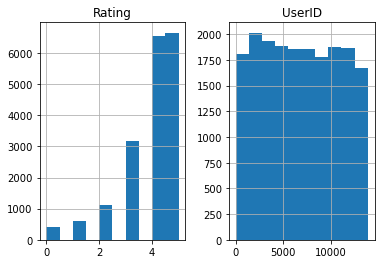

In [233]:
df_s.hist()

In [250]:
df_b = read_ratings('../data/big_dataset/')

Pattern : revs_*.csv
974


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc39dcca550>,
      dtype=object)

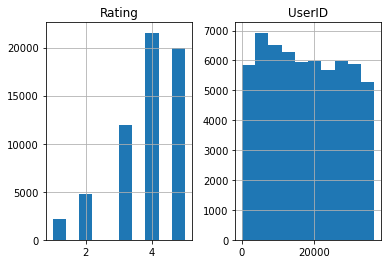

In [252]:
df_b.hist()

In [253]:
df_m = read_ratings('../data/big_data_temp/')

Pattern : revs_*.csv
293


In [256]:
len(df_m['Rating'])

85175

In [247]:
def rating_data_desc(df):
    num_users = len(df['UserID'].unique())
    num_books = len(df['ISBN'].unique())
    num_vals = len(df['Rating'])
    sparsity = 100 * num_vals / (num_users * num_vals)
    print(f'Number of users: {num_users}')
    print(f'Number of books: {num_books}')
    print(f'Number of ratings: {num_vals}')
    print(f'Matrix sparsity: {sparsity:.3f} %')

In [248]:
rating_data_desc(df_s)

rating_data_desc(df_b)

rating_data_desc(df_m)

Number of users: 13929
Number of books: 93
Number of ratings: 18550
Matrix sparsity: 0.007 %
Number of users: 37604
Number of books: 922
Number of ratings: 62024
Matrix sparsity: 0.003 %
Number of users: 12620
Number of books: 291
Number of ratings: 87076
Matrix sparsity: 0.008 %
